# Pip install 

In [45]:
# conda install -c conda-forge xgboost
# conda install -c conda-forge shap
# conda install -c conda-forge pdpbox

# Import Necessary Libraries

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import scipy.cluster.hierarchy as sch  
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Import/Clean Dataset

In [47]:
#Read in the dataset and index on the year
df = pd.read_csv("Research\Individual_tax_by_zip\irs_1040_13yrs.csv", 
                 index_col = "year")

#Rename cols 
df["num_exemptions"] = df["n2"]
df["st_local_income_tax_scheduled_amt"] = df["a18425"]
df["single_returns"] = df["mars1"]
df["tax_credit_amt"] = df["a07100"]
df["net_cap_gain_amt"] = df["a01000"]
df["joint_returns"] = df["mars2"]
df["earned_income_credit_amt"] = df["a59660"]
df["add_child_credit_amt"] = df["a11070"]
df["child_tax_cred_amt"] = df["a07220"]
df["for_tax_credit_amt"] = df["a07300"]
df["adj_gross_income"] = df["a00100"]
df["net_investment_income_tax_amt"] = df["a85300"]
df["contributions_sch_amt"] = df["a19700"]
df["real_estate_tax_sceduled_amt"] = df["a18500"]
df["mortgage_int_paid_amt"] = df["a19300"]
df["self_emp_tax_amt"] = df["a09400"]
df["num_of_returns_w_taxable_int"] = df["n00300"]

#Create a copy of the original df for Tree-Based Models
df1 = df.copy()

#Keep the most influential features for regression models
df = df.drop(df.columns.difference(["num_exemptions","st_local_income_tax_scheduled_amt","single_returns",
      "tax_credit_amt","net_cap_gain_amt","joint_returns","earned_income_credit_amt",
      "add_child_credit_amt","child_tax_cred_amt","for_tax_credit_amt","adj_gross_income"]),1)

#Keep the most influential features for tree based model            
df1 = df1.drop(df1.columns.difference(["net_cap_gain_amt","net_investment_income_tax_amt","contributions_sch_amt",
       "real_estate_tax_sceduled_amt","st_local_income_tax_scheduled_amt","mortgage_int_paid_amt",
       "self_emp_tax_amt","joint_returns","num_of_returns_w_taxable_int","adj_gross_income"]),1)

#Drop all NaNs from dfs
df = df.dropna()
df1 = df1.dropna()


In [48]:
#Check the shape of the df
print(df.shape)
df.head()

(676576, 11)


,num_exemptions,st_local_income_tax_scheduled_amt,single_returns,tax_credit_amt,net_cap_gain_amt,joint_returns,earned_income_credit_amt,add_child_credit_amt,child_tax_cred_amt,for_tax_credit_amt,adj_gross_income
year,,,,,,,,,,,
2013,4250.0,62.0,2510.0,160.0,169.0,190.0,2129.0,577.0,32.0,1.0,39072.0
2013,3340.0,16.0,1520.0,607.0,522.0,280.0,627.0,351.0,347.0,2.0,79567.0
2013,1840.0,38.0,740.0,380.0,857.0,290.0,0.0,36.0,256.0,5.0,70652.0
2013,1000.0,55.0,280.0,187.0,549.0,240.0,0.0,0.0,118.0,5.0,50034.0
2013,1710.0,267.0,320.0,371.0,3296.0,500.0,0.0,0.0,86.0,149.0,121370.0


In [49]:
#Check the shape of the copy df
print(df1.shape)
df1.head()

(676576, 10)


,st_local_income_tax_scheduled_amt,net_cap_gain_amt,joint_returns,adj_gross_income,net_investment_income_tax_amt,contributions_sch_amt,real_estate_tax_sceduled_amt,mortgage_int_paid_amt,self_emp_tax_amt,num_of_returns_w_taxable_int
year,,,,,,,,,,
2013,62.0,169.0,190.0,39072.0,0.0,125.0,269.0,429.0,298.0,440.0
2013,16.0,522.0,280.0,79567.0,0.0,302.0,516.0,969.0,426.0,340.0
2013,38.0,857.0,290.0,70652.0,0.0,511.0,743.0,1454.0,351.0,370.0
2013,55.0,549.0,240.0,50034.0,0.0,496.0,766.0,1288.0,405.0,270.0
2013,267.0,3296.0,500.0,121370.0,0.0,1748.0,2175.0,3767.0,888.0,520.0


# Split Data

In [50]:
#Define target variable 
target = "adj_gross_income"
#Assign target variable to y variable
y = df[target]
y1= df1[target]

#Drop target variable from X
X = df.drop(columns=target)
X1 = df1.drop(columns=target)

#Confirm the shapes of the split
print("The shape of X is:", X.shape)
print("The shape of X1 is:", X1.shape)
print("The shape of y is:", y.shape)
print("The shape of y1 is:", y1.shape)

The shape of X is: (676576, 10)
The shape of X1 is: (676576, 9)
The shape of y is: (676576,)
The shape of y1 is: (676576,)


In [51]:
#Assign 80% of the data to training set
X_train, y_train = X[:541260], y[:541260]
X1_train, y1_train = X1[:541260], y1[:541260]

#Assign 15% of the data to validation set
X_val, y_val = X[541260:-33830], y[541260:-33830]
X1_val, y1_val = X1[541260:-33830], y1[541260:-33830]

#Assign 5% of the data to test set
X_test, y_test = X[-33830:],y[-33830:]
X1_test, y1_test = X1[-33830:],y1[-33830:]

#Check the shape of the split data
print("The shape of X_train is:", X_train.shape)
print("The shape of y_train is:", y_train.shape)
print("The shape of X1_train is:", X1_train.shape)
print("The shape of y1_train is:", y1_train.shape)
print("")
print("The shape of X_val is:", X_val.shape)
print("The shape of y_val is:", y_val.shape)
print("The shape of X1_val is:", X1_val.shape)
print("The shape of y1_val is:", y1_val.shape)
print("")
print("The shape of X_test is:", X_test.shape)
print("The shape of y_test is:", y_test.shape)
print("The shape of X1_test is:", X1_test.shape)
print("The shape of y1_test is:", y1_test.shape)

The shape of X_train is: (541260, 10)
The shape of y_train is: (541260,)
The shape of X1_train is: (541260, 9)
The shape of y1_train is: (541260,)

The shape of X_val is: (101486, 10)
The shape of y_val is: (101486,)
The shape of X1_val is: (101486, 9)
The shape of y1_val is: (101486,)

The shape of X_test is: (33830, 10)
The shape of y_test is: (33830,)
The shape of X1_test is: (33830, 9)
The shape of y1_test is: (33830,)


# Calculate Baseline MAE

In [52]:
#calculate the mean of the adj income column for the training set
y_mean = y_train.mean()
y1_mean = y1_train.mean()

#create a list of mean values the length of the y_train set
y_pred = [y_mean] * len(y_train)
y1_pred = [y1_mean] * len(y1_train)

#calculate the mae for the training set
baseline_mae = mean_absolute_error(y_train,y_pred)
baseline_mae1 = mean_absolute_error(y1_train,y1_pred)

print("The baseline mae is",baseline_mae)
print("The baseline mae1 is",baseline_mae1)

The baseline mae is 68181.68533349526
The baseline mae1 is 68181.68533349526


# Ridge Regression Model

In [53]:
#Create a Ridge Regression model with an Ordinal Encoder
model_r = make_pipeline(Ridge(random_state=42))

#Fit the Ridge Regression model 
model_r.fit(X_train,y_train);

In [54]:
#The predicted y values of the training model
y_pred_train_r = model_r.predict(X_train)
#The training mae 
training_mae_r= mean_absolute_error(y_train,y_pred_train_r)

#The predicted y values of the val model
y_pred_val_r = model_r.predict(X_val)
#The validation mae 
validation_mae_r= mean_absolute_error(y_val,y_pred_val_r)

In [55]:
print("The training MAE:", training_mae_r)
print("The validation MAE:", validation_mae_r)
print("The training score is:", model_r.score(X_train,y_train))
print("The validation score is:", model_r.score(X_val, y_val))

The training MAE: 12134.599023580216
The validation MAE: 9359.868119880088
The training score is: 0.9550738011320721
The validation score is: 0.9690204169899005


# Tune Ridge Model

In [56]:
#Create a dictionary for hypertuning parameters
param_grid = {'ridge__alpha':range(1, 10,1),
             'ridge__max_iter':range(100,1000,100)}
#Use RandomizedSearch to test hyperparamaters
model_ridge = RandomizedSearchCV(model_r,
                          param_distributions = param_grid,
                          n_jobs=-1,
                          cv=5,
                          verbose=1)
#Fit tuned model for testing
model_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ridge',
                                              Ridge(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'ridge__alpha': range(1, 10),
                                        'ridge__max_iter': range(100, 1000, 100)},
                   verbose=1)

In [57]:
#Confirm best parameters
print(model_ridge.best_params_)
#Assign optimal model to variable
model_r = model_ridge.best_estimator_

{'ridge__max_iter': 100, 'ridge__alpha': 9}


In [58]:
#Test model
print("The test MAE:", mean_absolute_error(y_test, model_r.predict(X_test)))
print("The test score is:", model_r.score(X_test, y_test))

The test MAE: 12235.653304060064
The test score is: 0.9301263743211979


# Visualize Ridge Model

In [59]:
#Validate model by testing permutation importance
perm_imp = permutation_importance(model_r,
                                 X_val,
                                 y_val,
                                 n_jobs=-1,
                                 random_state=42)

In [60]:
#Create dictionary to transfer to df
data = {"imp_mean": perm_imp["importances_mean"],
       "imp_std": perm_imp["importances_std"]}
#Create df for easy viewing 
importances= pd.DataFrame(data, index=X_val.columns).sort_values(by="imp_mean")
importances

,imp_mean,imp_std
joint_returns,0.022066,0.000140
earned_income_credit_amt,0.047275,0.000227
st_local_income_tax_scheduled_amt,0.137118,0.000089
for_tax_credit_amt,0.157266,0.000147
single_returns,0.180405,0.001012
add_child_credit_amt,0.181747,0.000819
net_cap_gain_amt,0.195110,0.000164
child_tax_cred_amt,0.332474,0.000958
tax_credit_amt,0.477759,0.000375
num_exemptions,2.702871,0.007247


Text(0.5, 1.0, 'The Most Importanct Features to Predict')

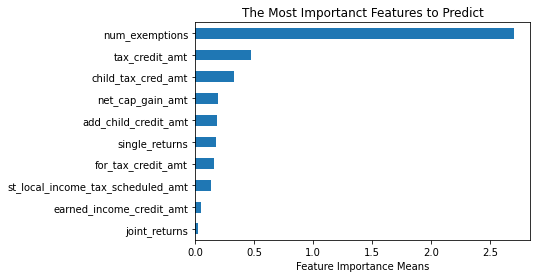

In [61]:
#Visualize feature importances 
importances["imp_mean"].tail(10).plot(kind="barh")
plt.xlabel("Feature Importance Means")
plt.title("The Most Importanct Features to Predict")

# RandomForestRegressor Model




In [62]:
#Create tree based model
model_rf = make_pipeline(RandomForestRegressor(random_state=42, n_jobs=-1)
)
#Fit randomforest model
model_rf.fit(X1_train, y1_train);

In [63]:
#The predicted y values of the training model
y_pred_train_rf = model_rf.predict(X1_train)
#The training mae 
training_mae_rf = mean_absolute_error(y1_train,y_pred_train_rf)

#The predicted y values of the val model
y_pred_val_rf = model_rf.predict(X1_val)
#The validation mae 
validation_mae_rf = mean_absolute_error(y1_val,y_pred_val_rf)

In [64]:
#Calculate MAE/Score for Tree-based Model
print("The training MAE:", training_mae_rf)
print("The validation MAE:", validation_mae_rf)
print("The training score is:", model_rf.score(X1_train,y1_train))
print("The validation score is:", model_rf.score(X1_val, y1_val))

The training MAE: 2106.5961626445073
The validation MAE: 4191.334343844921
The training score is: 0.9984347036142615
The validation score is: 0.9899666869244281


# Tune RandomForest Model 

In [65]:
#Create Dictionary for hyperparameter testing 
param_grid_2 = {'randomforestregressor__n_estimators':range(60,100,10),
                'randomforestregressor__max_depth':range(10,20,5)}

#Utilize RandomizedSearch for hyperparameter tuning
model_randomforest = RandomizedSearchCV(model_rf,
                          param_distributions = param_grid_2,
                          n_jobs=-1,
                          cv=3,
                          verbose=1)
#Fit Model for testing
model_randomforest.fit(X1_train, y1_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('randomforestregressor',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': range(10, 20, 5),
                                        'randomforestregressor__n_estimators': range(60, 100, 10)},
                   verbose=1)

In [66]:
#Confirm optimal parameters
print(model_randomforest.best_params_)
#Assign optimal model
model_rf = model_randomforest.best_estimator_

{'randomforestregressor__n_estimators': 70, 'randomforestregressor__max_depth': 15}


In [67]:
#Test model on test data
print("The test MAE:", mean_absolute_error(y1_test, model_rf.predict(X1_test)))
print("The test score is:", model_rf.score(X1_test, y1_test))

The test MAE: 5551.571457273418
The test score is: 0.9897222359862173


# Visualize RandomForest Model


In [68]:
#Grab feature importances
importances = model_rf.named_steps["randomforestregressor"].feature_importances_
features = X1_train.columns
feat_imp = pd.Series(importances, index = features).sort_values()
feat_imp

num_of_returns_w_taxable_int         0.017974
joint_returns                        0.025857
self_emp_tax_amt                     0.034036
st_local_income_tax_scheduled_amt    0.042082
mortgage_int_paid_amt                0.049610
real_estate_tax_sceduled_amt         0.051237
contributions_sch_amt                0.209779
net_investment_income_tax_amt        0.270284
net_cap_gain_amt                     0.299140
dtype: float64

Text(0.5, 1.0, 'The most important features to predict')

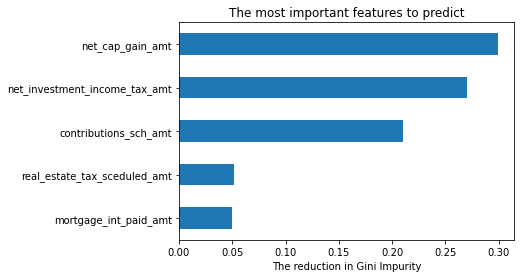

In [69]:
#Visualize Feature importances
feat_imp.tail().plot(kind="barh")
plt.xlabel("The reduction in Gini Impurity")
plt.title("The most important features to predict")